# 6. Target Encoding

- `One-Hot`, `Label`이랑은 또다른 범주임!

In [3]:
import pandas as pd

autos = pd.read_csv("data/autos.csv")

## Target Encoding
- 여기선 가격을 범주로 묶는 걸 설명함
    - 원래 범주가 `make`였는데 이들에 대해 `groupby`를 때려서 나온 값을 새로운 범주로 삼는 거임
    - 즉, 묶이는 애들은 똑같은데 이들의 이름만 다른 거임

In [4]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


## Smoothing
- 위의 경우 몇 가지 문제가 있다.
1. 새로운 범주 : 학습 때 알려지지 않은 새로운 범주가 들어온다고 했을 때, 이를 새로운 범주로 두지 않고 기존 범주에 합침
2. 희귀한 범주 : `평균`이라는 값 자체를 봤을 때 데이터의 수량을 파악할 수 없음. 
    - 가령 1대만 있다고 하면 평균이 아니라 그냥 차량 1대의 값이 되는 거임
    - 이는 과적합을 낳을 가능성이 있음

- 이러한 문제를 해결하는 방법으로 `Smoothing`이 있다 : **범주 내의 평균과 전체 평균을 혼합**하는 것
    - 희귀 평균은 범주 평균에 대한 가중치가 적고
    - 누락된 범주는 전체 평균을 얻는다
    
$ encoding = weight * inCategory + (1 - weight) * overall $  
- `weight`값은 0 ~ 1 사이의 값을 가지며, `m-estimate`로 얻을 수 있음    

$ weight = n / (n + m) $  


- n은 카테고리의 총 출현 수, m은 `smoothing factor`이다. m값이 클수록 전체 추정 가중치가 커짐

![9](Images/9.png)
- **m값을 선택할 때, 카테고리가 얼마나 noisy한지를 고려해야 한다.**
- 제품마다 가격이 크게 다르다면 m값이 커야 하고, 제품의 평균 가격이 안정적이라면 m값이 작아져도 좋다.

### 타겟 인코딩이 유용한 경우
- 카디널리티가 높은 경우(낮은 중복도, 많은 고유값) : 원핫인코딩은 차원이 너무 커질 수 있고, 레이블 인코딩은 부적합할 수 있음
    - 타겟 인코딩은 타겟과의 관계를 고려하여 범주의 숫자를 추출해냄
- 특성 계산에 대한 성능이 좋지 않더라도, 범주형 피쳐가 중요한 경우가 있다. 타겟 인코딩은 피쳐의 유용성을 높여줌

## 예제 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("./data/movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


- 3000개가 넘는 범주가 있고, `Zipcode` 특성은 타겟 인코딩이 될 좋은 특성이다. 
- 샘플 수가 100만개가 넘기 때문에 일부만을 이용함

In [18]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac = 0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

- `category_encoder`는 `scikit-learn-contrib`에 있음

In [20]:
from category_encoders import MEstimateEncoder

encoder = MEstimateEncoder(cols = ['Zipcode'
], m = 5.0)

encoder.fit(X_encode, y_encode)

X_train = encoder.transform(X_pretrain)

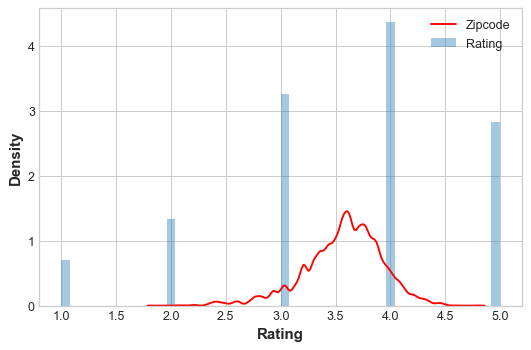

In [21]:
plt.figure(dpi = 90)
ax = sns.distplot(y, kde = False, norm_hist = True)
ax = sns.kdeplot(X_train.Zipcode, color = 'r', ax = ax)
ax.set_xlabel('Rating')
ax.legend(labels = ['Zipcode', 'Rating'])